### import necessary packages:

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import datetime


# Set pyplot font style to Computer Modern and enable LaTeX code...

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

In [18]:
df = pd.read_excel('flexpowerdata.xlsx',sheet_name='DE_Wind_PV_Prices')

# truncate data frame to only include 2021 entries. df_2021 has 35040 rows, which should be correct. (365 * 24 * 4)
df_2021 = df[df['time']<'2022-01-01'] 

### Task 1:

#### Calculate total Wind and PV generation in 2021 according to Day-Ahead and Intraday Forecast respectively.

In [19]:
wind_da_total = np.sum(df_2021['Wind Day Ahead Forecast [in MW]'].values)/4/1000000 # divide by 10**6 to get value in TWh.
wind_id_total = np.sum(df_2021['Wind Intraday Forecast [in MW]'].values)/4/1000000
pv_da_total = np.sum(df_2021['PV Day Ahead Forecast [in MW]'].values)/4/1000000
pv_id_total = np.sum(df_2021['PV Intraday Forecast [in MW]'].values)/4/1000000

In [20]:
print('Day-Ahead Wind Total: ', np.round(wind_da_total,decimals=2),'TWh')
print('Intraday Wind Total: ', np.round(wind_id_total,decimals=2),'TWh')
print('Day-Ahead PV Total: ', np.round(pv_da_total,decimals=2),'TWh')
print('Intraday PV Total: ', np.round(pv_id_total,decimals=2),'TWh')

Day-Ahead Wind Total:  115.4 TWh
Intraday Wind Total:  113.48 TWh
Day-Ahead PV Total:  46.09 TWh
Intraday PV Total:  46.69 TWh


### Task 2:
#### Show daily average Wind/PV production in 2021 according to Day-Ahead and Intraday forecasts respectively.

In [21]:
da_wind = []
id_wind = []
da_pv = []
id_pv = []
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    date_b = date_a + datetime.timedelta(days=1) # i use [date_a, date_b] as the interval to select all 96 entries of each individual day in the following lines.

    da_wind.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values)) # we append the mean of all 96 Wind Production forecasts of given day
    id_wind.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Intraday Forecast [in MW]'].values))

    da_pv.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values))
    id_pv.append(np.mean(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Intraday Forecast [in MW]'].values))

    dates.append(date_a)

    date_a = date_b # i shift date_a one day forward to iterate.


''

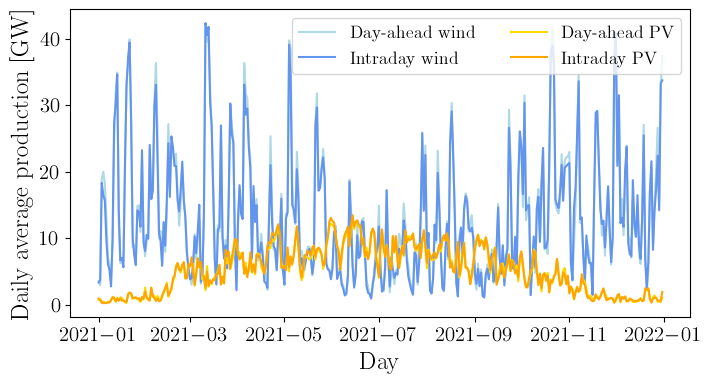

In [22]:
plt.figure(figsize=(8,4))

plt.plot(dates,da_wind,color='lightblue',label='Day-ahead wind')
plt.plot(dates,id_wind,color='cornflowerblue',label='Intraday wind')

plt.plot(dates,da_pv,color='gold',label='Day-ahead PV')
plt.plot(dates,id_pv,color='orange',label='Intraday PV')

plt.yticks(ticks=[0,10000,20000,30000,40000],labels=[0,10,20,30,40],fontsize=15)
plt.xticks(fontsize=15)

plt.ylabel('Daily average production [GW]',fontsize=18)
plt.xlabel('Day',fontsize=18)

plt.legend(fontsize=13, ncols=2)
;

### Task 3:
#### Calculate the average value of Wind and PV Power according to the Day-ahead forecasts and Day-Ahead prices.

In [8]:
hour_prod_wind = [] # collect hourly wind production for all 8760 hours in 2021
hour_prod_pv = [] # collect hourly PV production for all 8760 hours in 2021
hour_price = [] # collect hourly prices for all 8760 hours in 2021
dates = [] #collect dates

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365*24):

    date_b = date_a + datetime.timedelta(hours=1)

    hour_prod_wind.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values/4))    # calculate the average of the 4 wind power forecasts of each hour by np.sum(...)/4.   np.mean() would be more elegant i guess, but caused some weird issues here so i worked around. 
    hour_prod_pv.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values/4))

    hour_price.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values/4))

    dates.append(date_a)

    date_a = date_b


In [9]:
print('Average Day-Ahead price in 2021:', np.round(np.mean(hour_price),decimals=2), 'EUR/MWh')
print('Average Day-Ahead price for Wind Power in 2021:', np.round(np.sum((np.asarray(hour_prod_wind) * hour_price) / np.sum(hour_prod_wind)),decimals=2), 'EUR/MWh')
print('Average Day-Ahead price for PV Power 2021:', np.round(np.sum((np.asarray(hour_prod_pv) * hour_price) / np.sum(hour_prod_pv)),decimals=2), 'EUR/MWh')

Average Day-Ahead price in 2021: 96.85 EUR/MWh
Average Day-Ahead price for Wind Power in 2021: 81.41 EUR/MWh
Average Day-Ahead price for PV Power 2021: 76.89 EUR/MWh


It is known that VREs have a lower market value compared to non-variable sources. 

Simple example: If the sun shines, it typically shines for most solar plants in Germany (or even Europe), which causes high solar power production. PV power has very low marginal cost and according to merit order principle, this pushes the total market clearing price, since more expensive generation sources are turned off.

See "The market value of variable renewables: The effect of solar wind power variability on their relative price" by Lion Hirth, which is a well-known paper on that topic.

### Task 4:
#### Calculate the average Day-Ahead prices on the days with highest and lowest Wind+PV production.

In [24]:
day_prod_res = [] # daily production by renewable sources. one entry for each day in 2021.
day_price = [] # daily average Day-Ahead price for each day in 2021. 
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    date_b = date_a + datetime.timedelta(days=1)

    day_prod_res.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Wind Day Ahead Forecast [in MW]'].values/96) + np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['PV Day Ahead Forecast [in MW]'].values/96))
    
    day_price.append(np.sum(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values/96))

    dates.append(date_a)

    date_a = date_b

In [25]:
print('Price at day with highest RES generation:',np.round(day_price[np.argmax(day_prod_res)],decimals=2),'EUR/MWh') # print daily average price of day with highest RE production in 2021.
print('Price at day with lowest RES generation:',np.round(day_price[np.argmin(day_prod_res)],decimals=2),'EUR/MWh') # print daily average price of day with lowest RE production in 2021.

Price at day with highest RES generation: 22.29 EUR/MWh
Price at day with lowest RES generation: 237.46 EUR/MWh


In order to satisfy demand, generation sources are broadly determined by the merit order principle. Power sources with lowest marginal cost come first. Wind and PV are the cheapest sources (almost 0 generation cost). For example at days with high Wind and PV generation, ideally on a Saturday or Sunday, Wind and PV alone might be enough to satisfy demand. On the other hand, on days with high demand (weekdays) and very little RES power generation, power generation also comes from up the curve, which are generation types with very high production costs (gas and even oil).

### Task 5:
#### Calculate average hourly Day-Ahead price on weekdays vs. weekends.

In [12]:
prices_weekday = []
prices_weekend = []
for i in range(len(df_2021)):
    if df_2021['time'][i].weekday() <= 4:   # use timestamp.weekday() to check if timestamp is on weekday or not.
        prices_weekday.append(df_2021['Day Ahead Price hourly [in EUR/MWh]'][i])
    else:
        prices_weekend.append(df_2021['Day Ahead Price hourly [in EUR/MWh]'][i])


In [13]:
print('Average Day-Ahead price during weekends in 2021:', np.round(np.mean(prices_weekend),decimals=2),'EUR/MWh')
print('Average Day-Ahead price during weekdays in 2021:', np.round(np.mean(prices_weekday),decimals=2),'EUR/MWh')

Average Day-Ahead price during weekends in 2021: 77.98 EUR/MWh
Average Day-Ahead price during weekdays in 2021: 104.37 EUR/MWh


This is due to overall lower demand on the saturdays and sundays (i guess mainly because many industrial facilities are closed). Therefore due to the merit order principle, demand is typically satisfied lower down the curve.

### Task 6:
#### Arbitrage with a 1MWh battery storage and one charge-discharge cycle per day.

In [14]:
day_price_low = []
day_price_high = []
dates = []

date_a = datetime.datetime(2021, 1, 1, 0, 0, 0)

for _ in range(365):

    date_b = date_a + datetime.timedelta(days=1)

    day_price_low.append(np.min(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values))
    day_price_high.append(np.max(df_2021[(df_2021['time']>=date_a) & (df_2021['time']<date_b)]['Day Ahead Price hourly [in EUR/MWh]'].values))
  
    dates.append(date_a)

    date_a = date_b

In [15]:
len(day_price_high)

365

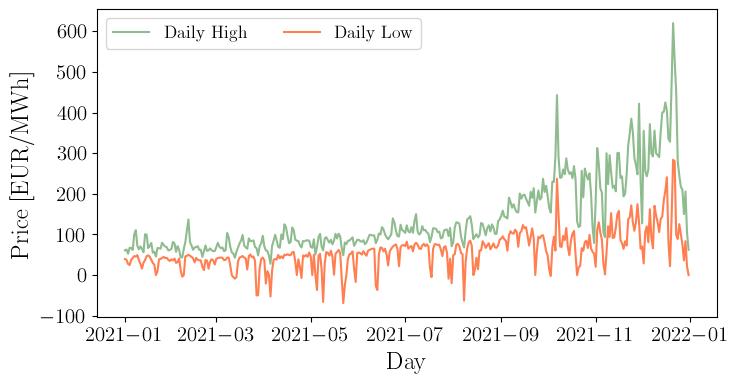

In [16]:
plt.figure(figsize=(8,4))

plt.plot(dates, day_price_high,color='darkseagreen',label='Daily High')
plt.plot(dates, day_price_low,color='coral',label='Daily Low')

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.ylabel('Price [EUR/MWh]',fontsize=18)
plt.xlabel('Day',fontsize=18)

plt.legend(fontsize=13, ncols=2)

In [17]:
print('Arbing 1MWH per day yields:', np.round(np.sum(np.asarray(day_price_high)-day_price_low),decimals=2), 'EUR for total 2021.')

Arbing 1MWH per day yields: 29311.6 EUR for total 2021. This approach is simplified. This is just the difference between daily high and daily low. Caveats: Perfect foresight required. Daily high price might occur before daily Low price.


This approach is simplified. This is just the difference between daily high and daily low. Caveats: Perfect foresight required. Daily high price might occur before daily Low price.